In [1]:
import os
import numpy as np
import pandas as pd 
import datetime as dt
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize' : 15, 'axes.titleweight': 'bold',\
                     'axes.labelsize' : 13, 'axes.labelweight': 'bold',\
                     'font.weight': 'bold','font.sans-serif':'Arial'})
# import matplotlib converters for date processing
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [147]:
# plt.rcParams.keys()

# Notice: To download all the CSV files of price data for below tickers and contracts lists, please look for the commented codes at the very bottom

- 因为数据格式都一样，因此就只include了用来做sample的两份data。

- ticker data需要保存在叫stock_ETF的folder里面，contract data需要保存在叫futures_main的folder里面，或者可以更改一下路径使用都可以。

In [2]:
tickers = ['SPY','QQQ','DIA','NEE','AMZN','WMT','XOM','JPM','JNJ','UNP','LIN','AMT','GOOG','AAPL']
contracts = \
[
'T.CFX', #十债加权-CFFEX10年期国债期货
'TF.CFX', #五债加权-CFFEX5年期国债期货
'AU.SHF', #沪金-黄金主力
'AG.SHF', #沪银-白银主力
'CU.SHF', #沪铜-沪铜主力
'NI.SHF', #沪镍-沪镍主力
'AL.SHF', #沪铝-沪铝主力
'RB.SHF', #螺纹-螺纹钢主力
'I.DCE', #铁矿-铁矿石主力
'J.DCE', #焦炭-焦炭主力
'JM.DCE', #焦煤-焦煤主力
'ZC.ZCE', #郑煤-动力煤主力
'RU.SHF', #橡胶-橡胶主力
'TA.ZCE', #PTA-PTA主力
'MA.ZCE', #郑醇-甲醇主力
'M.DCE', #豆粕-豆粕主力
'P.DCE', #棕榈油-棕榈油主力
'CF.ZCE', #郑棉-棉花主力
'SR.ZCE', #白糖-白糖主力
'C.DCE', #玉米-玉米主力
'SP.SHF', #纸浆-纸浆主力
'CJ.ZCE', #红枣-红枣主力
'ZN.SHF', #沪锌-沪锌主力
'PB.SHF', #沪铅-沪铅主力
'SN.SHF', #沪锡-沪锡主力
'SS.SHF', #SS-不锈钢主力
'HC.SHF', #热卷-热轧卷板主力
'FG.ZCE', #玻璃-玻璃主力
'EB.DCE', #EB-苯乙烯主力
'UR.ZCE', #尿素-尿素主力
'EG.DCE', #EG-乙二醇主力
'SA.ZCE', #纯碱-纯碱主力
#NR-20号胶(missing)
'V.DCE', #PVC-PVC主力
'PP.DCE', #PP-聚丙烯主力
'SM.ZCE', #锰硅-锰硅主力
'SF.ZCE', #硅铁-硅铁主力
'A.DCE', #豆一主力
'B.DCE', #豆二主力
'Y.DCE', #豆油-豆油主力
'OI.ZCE', #郑油-菜油主力
'RM.ZCE', #菜粕-菜油主力
'FU.SHF', #燃油-燃油主力
'PG.DCE', #LPG-LPG主力
'BU.SHF', #沥青-沥青主力
#原油-上期原油 (missing)
'AP.ZCE', #苹果-苹果主力
'L.DCE', #塑料-塑料主力
'CS.DCE', #淀粉-玉米淀粉主力
]

In [3]:
class Indicator(object):
    def __init__(self, plot_window=100):
        # set up the plot window
        # default is last 100 days
        self.pw = plot_window
        
        # set up sigal results output folders
        if not os.path.exists('ticker_signals'):
                os.makedirs('ticker_signals')
                
        if not os.path.exists('contract_signals'):
                os.makedirs('contract_signals')
    
    def set_plot_window(self):
        pass
    
    # read csv files
    def read_file(self,ticker=None,contract=None):
        if ticker:
            # get single ticker OHLC, Volume in pandas dataframe
            data = pd.read_csv('stock_ETF/%s.csv' % ticker)
            data['Date'] = [dt.datetime.strptime(date,'%Y-%m-%d') for date in data['Date']]
            data.set_index('Date',inplace=True)
        
        if contract:
            # get single main contract OHLC, Volume in pandas dataframe
            data = pd.read_csv('futures_main/%s.csv' % contract)[::-1]
            data['trade_date'] = [str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:] for date in data['trade_date']]
            data['trade_date'] = [dt.datetime.strptime(date,'%Y-%m-%d') for date in data['trade_date']]
            data.columns = ['Date','ts_code','mapping_ts_code','Open','High','Low','Close','Settle','Volume','Open_Interest']
            data.set_index('Date',inplace=True)
        
        return data
    
    # Indicator 1: Bollinger Band
    def bollinger_band(self,window=20,ticker=None,contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
        
        #calculate typical price & std
        data['typical_price'] = (data['High'] + data['Low'] + data['Close'])/3
        data['std'] = data['typical_price'].rolling(window=20).std()
        
        # middle,upper,lower band
        data['middle_band'] = data['typical_price'].rolling(window=window).mean()
        data['upper_band'] = data['middle_band'] + data['std']*2
        data['lower_band'] = data['middle_band'] - data['std']*2
             
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['middle_band'].plot(label='middle_band',color='#2478F0',alpha=0.5)
        plot_df['upper_band'].plot(label='upper_band',color='#DB2F2A',alpha=0.5)
        plot_df['lower_band'].plot(label='lower_band',color='#FA7F25',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.fill_between(plot_df.index,plot_df['upper_band'],plot_df['lower_band'],alpha=0.2)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] < data['lower_band'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] > data['middle_band'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_BB.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_BB.csv' % contract) 
            
            
    # Indicator 2 and 18: ATR and Chandelier Exit
    def ATR(self,window=14,ticker=None,contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        #True Range
        TR = []
        for i in range(len(data)):
            TR.append(max(abs(data['High'].iloc[i] - data['Low'].iloc[i]), abs(data['High'].iloc[i] - data['Close'].shift(1).iloc[i]), abs(data['Low'].iloc[i] - data['Close'].shift(1).iloc[i])))
            
        data['TR'] = TR
        data['ATR'] = data['TR'].rolling(window=window).mean()
        
        # output signals
        signals = []
        highest_high = []
        long_index = None
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] > data['Close'].shift(-1).iloc[i] + data['ATR'].iloc[i]:
                position = 'Long'
                long_index = i 
                
            if position == 'Long' and data['Close'].iloc[i] < max(data['High'].iloc[long_index:i+1]) - 3 * data['ATR'].iloc[i]:
                position = 'Out'
                long_index = None
                
            if long_index:
                highest_high.append(max(data['High'].iloc[long_index:i+1]))
            else:
                highest_high.append(np.nan)
                
            signals.append(position)
        data['signal'] = signals
        data['highest_high'] = highest_high
        
        if ticker:
            data.to_csv('ticker_signals/%s_ATR_Chandelier.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_ATR_Chandelier.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        (plot_df['ATR'] + plot_df['Close'].shift(-1)).plot(label='ATR + Previous Close',color='#2478F0',alpha=0.4)
        (plot_df['highest_high'] - 3*plot_df['ATR']).plot(label='Chandelier Exit',color='#FA7F25',alpha=0.4)
#         plot_df['ATR'].plot(label='ATR',color='#FA7F25',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    
    # Indicator 3: Ichimoku Cloud
    def ichi_cloud(self,ticker=None,contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        data['conversion_line'] = (data['High'].rolling(window=9).max() + data['Low'].rolling(window=9).min()) / 2
        data['base_line'] = (data['High'].rolling(window=26).max() + data['Low'].rolling(window=26).min()) / 2
        data['leading_span_A'] = (data['conversion_line'] + data['base_line']) / 2
        data['leading_span_B'] = (data['High'].rolling(window=52).max() + data['Low'].rolling(window=52).min()) / 2
        data['lagging_span'] = data['Close'].shift(26)
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['conversion_line'].iloc[i] > data['base_line'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['conversion_line'].iloc[i] < data['base_line'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_cloud.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_cloud.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['conversion_line'].plot(label='conversion_line',color='#2478F0',alpha=0.5)
        plot_df['base_line'].plot(label='base_line',color='g',alpha=0.5)
        plot_df['leading_span_A'].plot(label='leading_span_A',color='#FA7F25',alpha=0.5)
        plot_df['leading_span_B'].plot(label='leading_span_B',color='#FA7F25',alpha=0.5)
#         plot_df['lagging_span'].plot(label='lagging_span',color='#DB2F2A',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.fill_between(plot_df.index,plot_df['leading_span_A'],plot_df['leading_span_B'],alpha=0.2)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
        
    # Indicator 4: KAMA indicator
    def kama(self, fast_window=2, slow_window=30, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        data['efficiency_ratio'] = abs(data['Close'] - data['Close'].shift(10)) / abs(data['Close'] - data['Close'].shift(1)).rolling(window=10).sum()
        scf = 2/(fast_window+1)
        scs = 2/(slow_window+1)
        data['weight'] = (data['efficiency_ratio'] * (scf-scs) + scs) ** 2
        
        # the initial value starts at day 11, its a 10-day average of close prices
        data['MA14'] = data['Close'].rolling(window=14).mean()
        KAMA = []
        for i in range(len(data)):
            if not pd.isnull(data['weight'].iloc[i]) and not pd.isnull(KAMA[i-1]):
                KAMA.append(data['weight'].iloc[i] * data['Close'].iloc[i] + (1 - data['weight'].iloc[i]) * KAMA[i-1])
            else: 
                 KAMA.append(data['MA14'].iloc[i])
        data['kama'] = KAMA
        
        # output signals: the initial signal should be 
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] > data['kama'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] < data['kama'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_kama.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_kama.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['kama'].plot(label='kama',color='#2478F0')
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    # Indicator 5: Keltner Channels
    def k_channels(self, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
        
        # middle band: EMA20 and decaying
        decay_factor = 2/(20+1)
        data['middle_band'] = data['Close'].ewm(span=20).mean()
        
        # True Range
        TR = []
        for i in range(len(data)):
            TR.append(max(abs(data['High'].iloc[i] - data['Low'].iloc[i]), abs(data['High'].iloc[i] - data['Close'].shift(1).iloc[i]), abs(data['Low'].iloc[i] - data['Close'].shift(1).iloc[i])))
            
        data['TR'] = TR
        data['ATR'] = data['TR'].rolling(window=14).mean()
        
        # keltner channels
        multiplier = 2
        data['upper_band'] = data['middle_band'] + multiplier * data['ATR']
        data['lower_band'] = data['middle_band'] - multiplier * data['ATR']
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] < data['lower_band'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] > data['upper_band'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_k_channels.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_k_channels.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['middle_band'].plot(label='middle_band',color='#2478F0',alpha=0.5)
        plot_df['upper_band'].plot(label='upper_band',color='#DB2F2A',alpha=0.5)
        plot_df['lower_band'].plot(label='lower_band',color='#FA7F25',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.fill_between(plot_df.index,plot_df['upper_band'],plot_df['lower_band'],alpha=0.2)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    # Indicator 6: simple moving average: assume 14 days and only consider one MA line.
    def sma(self, window=14, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        data['sma'+str(window)] = data['Close'].rolling(window=window).mean()
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] > data['sma'+str(window)].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] < data['sma'+str(window)].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_sma%d.csv' % (ticker,window))
        else:
            data.to_csv('contract_signals/%s_sma%d.csv' % (contract,window))
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['sma'+str(window)].plot(label='sma'+str(window),color='#2478F0',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    # Indicator 6: Exponential moving average: assume 14 days and only consider one MA line.
    def ema(self, window=14, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        data['ema'+str(window)] = data['Close'].ewm(span=14).mean()
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] > data['ema'+str(window)].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] < data['ema'+str(window)].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_ema%d.csv' % (ticker,window))
        else:
            data.to_csv('contract_signals/%s_ema%d.csv' % (contract,window))
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        
        plot_df['ema'+str(window)].plot(label='ema'+str(window),color='#2478F0',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    # Indicator 7: Moving Average Envelopes
    # default using sma: set sma=False uses ema
    def ma_envelope(self, sma=True, window=14, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        if sma:
            data['sma'+str(window)] = data['Close'].rolling(window=window).mean()
            data['upper_envelope_line'] = data['sma'+str(window)] * 1.05
            data['lower_envelope_line'] = data['sma'+str(window)] * 0.95
            
            # plots
            plot_df = data.iloc[-self.pw:]
            fig = plt.figure(figsize=(10,6))
            plt.title('%s' % ticker if ticker else contract)

            plot_df['sma'+str(window)].plot(label='sma'+str(window),color='#2478F0',alpha=0.5)
            plot_df['upper_envelope_line'].plot(label='upper_envelope_line',color='#DB2F2A',alpha=0.5)
            plot_df['lower_envelope_line'].plot(label='lower_envelope_line',color='#FA7F25',alpha=0.5)
            plot_df['Close'].plot(label='Close Price',color='r')
            plt.fill_between(plot_df.index,plot_df['upper_envelope_line'],plot_df['lower_envelope_line'],alpha=0.2)
            plt.xlabel('Date')
            plt.ylabel('Price') 
            plt.legend()
            
        else:
            data['ema'+str(window)] = data['Close'].ewm(span=14).mean()
            data['upper_envelope_line'] = data['ema'+str(window)] * 1.05
            data['lower_envelope_line'] = data['ema'+str(window)] * 0.95
            
            # plots
            plot_df = data.iloc[-self.pw:]
            fig = plt.figure(figsize=(10,6))
            plt.title('%s' % ticker if ticker else contract)

            plot_df['ema'+str(window)].plot(label='ema'+str(window),color='#2478F0',alpha=0.5)
            plot_df['upper_envelope_line'].plot(label='upper_envelope_line',color='#DB2F2A',alpha=0.5)
            plot_df['lower_envelope_line'].plot(label='lower_envelope_line',color='#FA7F25',alpha=0.5)
            plot_df['Close'].plot(label='Close Price',color='r')
            plt.fill_between(plot_df.index,plot_df['upper_envelope_line'],plot_df['lower_envelope_line'],alpha=0.2)
            plt.xlabel('Date')
            plt.ylabel('Price') 
            plt.legend()
         
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] < data['lower_envelope_line'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] > data['upper_envelope_line'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_ma_envelope%d.csv' % (ticker,window))
        else:
            data.to_csv('contract_signals/%s_ma_envelope%d.csv' % (contract,window))
            
    # Indicator 8: Parabolic SAR
    def psar(self,ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
        
        data['trend'] = np.where(data['Close'] > data['Close'].shift(1), 'up','down')
#         extreme_points = [None]
#         acceleration_factors = [None]
#         trends = [None]
#         factor = 0
#         up = 0
#         down = 0
# #         for i in range(1,len(data)):
# #             if data['Close'].iloc[i] > data.['Close'].iloc[i-1]
# #                 point = 
# #                 extreme_points.append()
#         pass

    # Indicator 9: Pivot Points
    def pivot(self,ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            
        # pivot point = (previous high + previous low + previous close) / 3
        data['pivot_point'] = (data['High'].shift(1) + data['Low'].shift(1) + data['Close'].shift(1))/3
        data['resistance1'] = data['pivot_point'] * 2 - data['Low'].shift(1)
        data['resistance2'] = data['pivot_point'] + data['High'].shift(1) - data['Low'].shift(1)
        data['support1'] = data['pivot_point'] * 2 - data['High'].shift(1)
        data['support2'] = data['pivot_point'] - data['High'].shift(1) + data['Low'].shift(1)
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] > data['pivot_point'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] > data['resistance1'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_pivot.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_pivot.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)

        plot_df['pivot_point'].plot(label='pivot_point',color='#2478F0',alpha=0.5)
        plot_df['resistance1'].plot(label='resistance1',color='#DB2F2A',alpha=0.5)
#         plot_df['resistance2'].plot(label='resistance2',color='#DB2F2A',alpha=0.5)
        plot_df['support1'].plot(label='support1',color='#FA7F25',alpha=0.5)
#         plot_df['support2'].plot(label='support2',color='#FA7F25',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.fill_between(plot_df.index,plot_df['resistance1'],plot_df['support1'],alpha=0.2)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
    
    # Indicator 10: Price Channels
    def price_channels(self, window=20, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
        
        # price channels
        data['upper_channel'] = data['High'].shift(1).rolling(window=window).max()
        data['lower_channel'] = data['Low'].shift(1).rolling(window=window).min()
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['Close'].iloc[i] < data['lower_channel'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['Close'].iloc[i] > data['upper_channel'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_price_channels.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_price_channels.csv' % contract)
        
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)

        plot_df['upper_channel'].plot(label='upper_channel',color='#DB2F2A',alpha=0.5)
        plot_df['lower_channel'].plot(label='lower_channel',color='#FA7F25',alpha=0.5)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.fill_between(plot_df.index,plot_df['upper_channel'],plot_df['lower_channel'],alpha=0.2)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()

    # Indicator 11: Price by Volume Chart (PBV) 
    def pv_chart(self):
        pass
    
    # Indicator 12: VWAP (needs intraday data, can't produce)
    def vwap(self):
        pass
    
    # Indicator 13: Zigzag 
    def zig(self):
        pass
    
    # Indicator 14: Accumulation/Distribution Line
    def ad_line(self, window=20, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            data.dropna(inplace=True)
  
        # Current Money Flow Volume
        data['cmfv'] = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) * data['Volume'] / (data['High'] - data['Low'])
        
        # Accumulation distribution line
        ad = [data['cmfv'].iloc[0]]
        for i in range(1,len(data)):
            if pd.isnull(data['cmfv'].iloc[i]):
                ad.append(ad[i-1])
            else:
                ad.append(ad[i-1] + data['cmfv'].iloc[i])
        data['ad_line'] = ad

        # output signals
        # assumed daily rate of change to replicate the divergence of accumulation/distribution line and market prices
        data['ad_rate_of_change'] = data['ad_line'].pct_change()
        data['close_rate_of_change'] = data['Close'].pct_change()
        
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['ad_rate_of_change'].iloc[i] > 0 and data['close_rate_of_change'].iloc[i] < 0:
                position = 'Long'
            if position == 'Long' and data['ad_rate_of_change'].iloc[i] < 0 and data['close_rate_of_change'].iloc[i] > 0:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_ad_line.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_ad_line.csv' % contract)
            
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)
        plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
        fig = plt.figure(figsize=(10,3))
        plot_df['ad_line'].plot(label='ad_line',color='#2478F0',alpha=0.5)
        plt.xlabel('Date')
        plt.legend()
        
    
    # Indicator 15 and 16: Aroon
    def aroon(self, window=25, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            data.dropna(inplace=True)
            
        data['since_low'] = data['Low'].rolling(window=window+1).apply(lambda x: x.argmin(), raw = True)
        data['since_high'] = data['High'].rolling(window=window+1).apply(lambda x: x.argmax(), raw = True)
        data['up'] = ((data['since_high']/25) *100)
        data['down'] = ((data['since_low'] / 25) * 100)
        data['oscillator'] = data['up'] - data['down']
        
        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['up'].iloc[i] > data['down'].iloc[i]:
                position = 'Long'
            if position == 'Long' and data['up'].iloc[i] < data['down'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_aroon.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_aroon.csv' % contract)
        
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)

        plot_df['up'].plot(label='up',color='#DB2F2A',alpha=0.5)
        plot_df['down'].plot(label='down',color='#FA7F25',alpha=0.5)
#         plot_df['Close'].plot(label='Close Price',color='r')
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()
        
        fig = plt.figure(figsize=(10,3))
        plot_df['oscillator'].plot(label='oscillator',color='#2478F0',alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
    
    # Indicator 17: ADX
    def _wilder_sum(self, data, n):
        data = data.dropna()

        nf = (n - 1) / n
        ws = [np.nan]*(n - 1) + [data[n - 1] + nf*sum(data[:n - 1])]

        for v in data[n:]:
            ws.append(v + ws[-1]*nf)

        return pd.Series(ws, index=data.index)
    
    def _ema(self, data, n, wilder=False):
        span = n if not wilder else 2*n - 1
        return data.ewm(span=span).mean()

    def adx(self, window=14, ticker=None, contract=None):
        if ticker:
            data = self.read_file(ticker=ticker)
        else:
            data = self.read_file(contract=contract)
            data.dropna(inplace=True)
        
        previous_close = data['Close'].shift(1)
        tr = data['High'].combine(previous_close, max) - data['Low'].combine(previous_close, min)
        data['atr'] = self._wilder_sum(tr, window)

        up = data['High'] - data['High'].shift(1)
        dn = data['Low'].shift(1) - data['Low']

        pos = ((up > dn) & (up > 0)) * up
        neg = ((dn > up) & (dn > 0)) * dn

        data['DI+'] = 100 * self._wilder_sum(pos, window) / data['atr']
        data['DI-'] = 100 * self._wilder_sum(neg, window) / data['atr']

        dx = 100 * np.abs((data['DI+'] - data['DI-'])/(data['DI+'] + data['DI-']))
        data['ADX'] = self._ema(dx, window, wilder=True)

        # output signals
        signals = []
        position = 'Out'
        for i in range(len(data)):
            if data['DI+'].iloc[i] > data['DI-'].iloc[i] and data['ADX'].iloc[i] > 20:
                position = 'Long'
            if position == 'Long' and data['DI+'].iloc[i] < data['DI-'].iloc[i]:
                position = 'Out'
                
            signals.append(position)
        data['signal'] = signals
        
        if ticker:
            data.to_csv('ticker_signals/%s_adx.csv' % ticker)
        else:
            data.to_csv('contract_signals/%s_adx.csv' % contract)
        
        # plots
        plot_df = data.iloc[-self.pw:]
        fig = plt.figure(figsize=(10,6))
        plt.title('%s' % ticker if ticker else contract)

        plot_df['DI-'].plot(label='DI-',color='#DB2F2A',alpha=0.5)
        plot_df['DI+'].plot(label='DI+',color='#FA7F25',alpha=0.5)
        plot_df['ADX'].plot(label='ADX',color='#2478F0',alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('Price') 
        plt.legend()

In [4]:
# initiate Indicator class
Ind = Indicator()

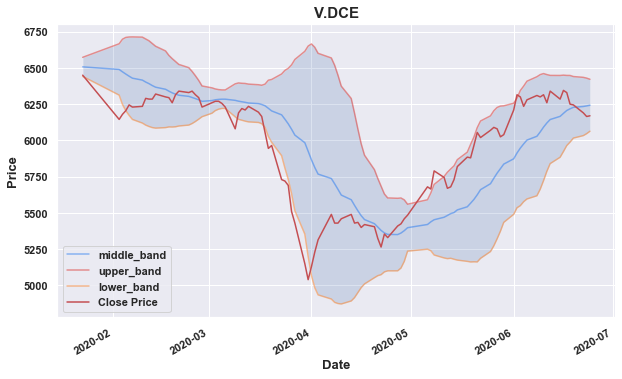

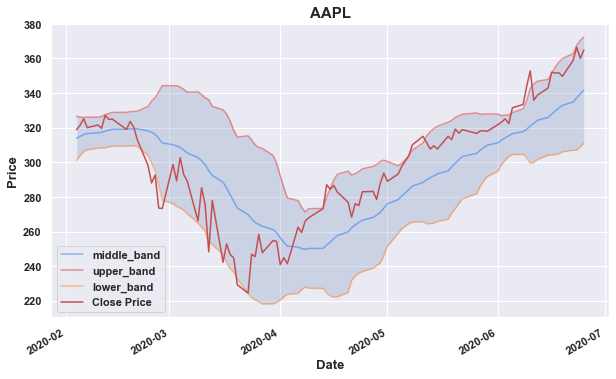

In [7]:
# Bollinger band
Ind.bollinger_band(contract='V.DCE')
Ind.bollinger_band(ticker='AAPL')

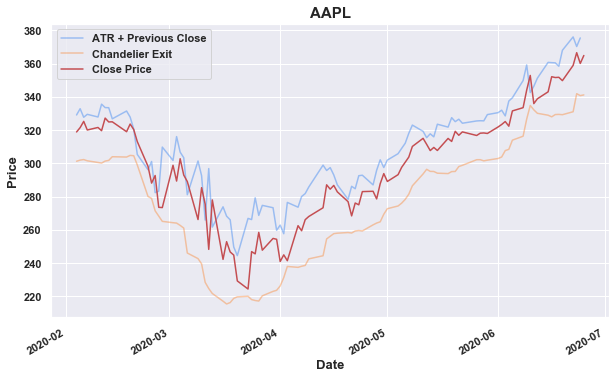

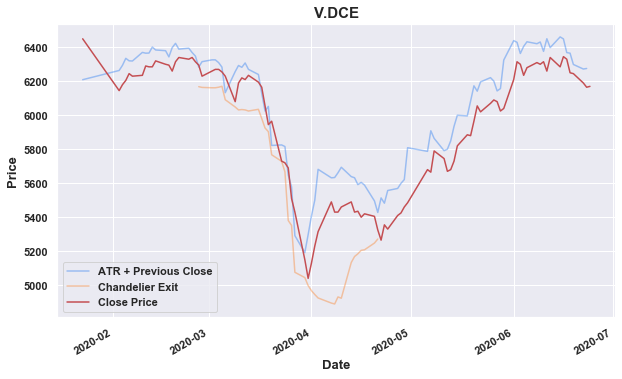

In [8]:
# ATR & Chandelier Exit
Ind.ATR(ticker='AAPL')
Ind.ATR(contract='V.DCE')

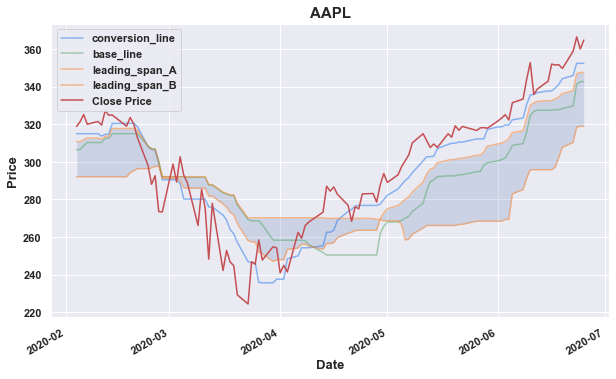

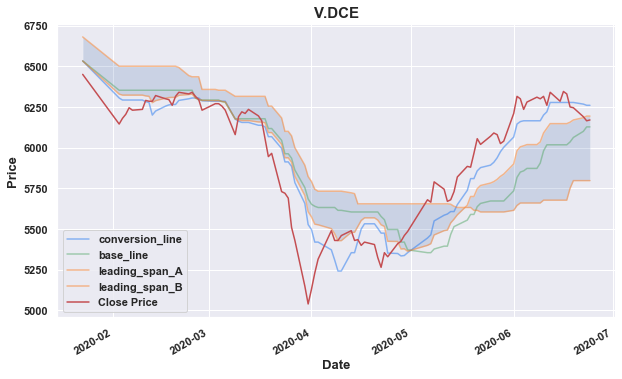

In [9]:
# Ichimoku cloud
Ind.ichi_cloud(ticker='AAPL')
Ind.ichi_cloud(contract='V.DCE')

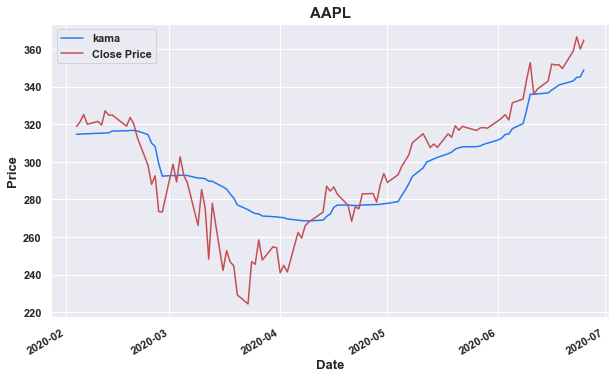

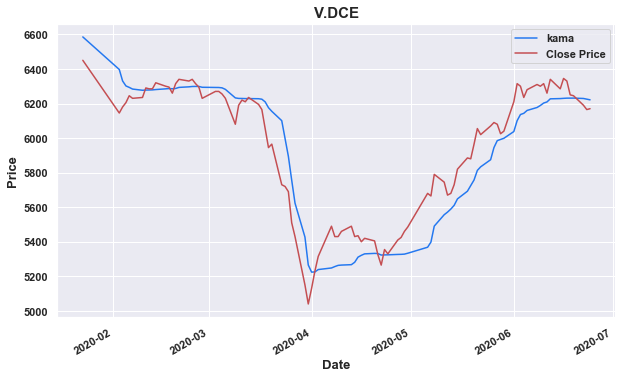

In [10]:
# KAMA
Ind.kama(ticker='AAPL')
Ind.kama(contract='V.DCE')

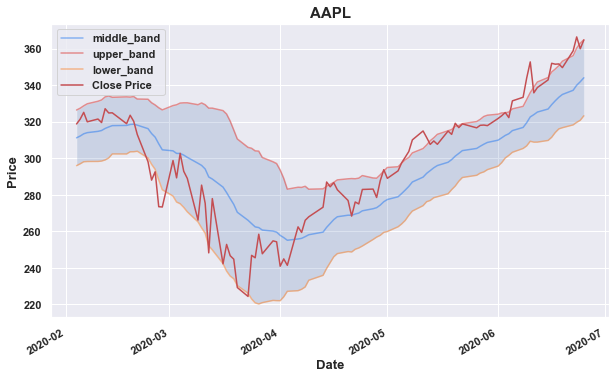

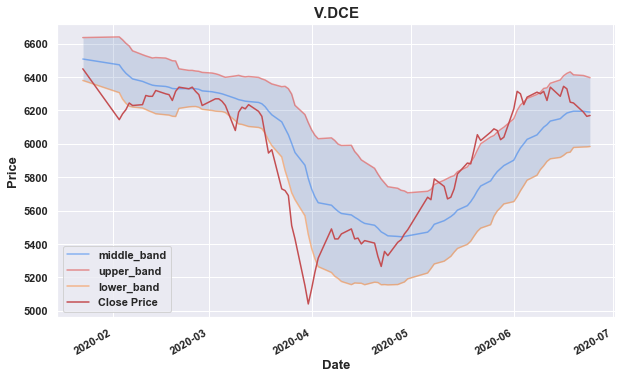

In [11]:
# Keltner Channels
Ind.k_channels(ticker='AAPL')
Ind.k_channels(contract='V.DCE')

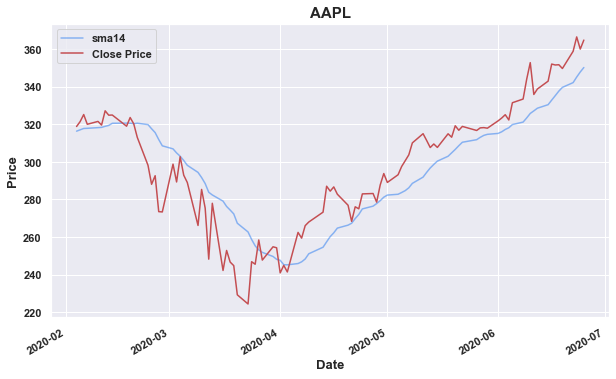

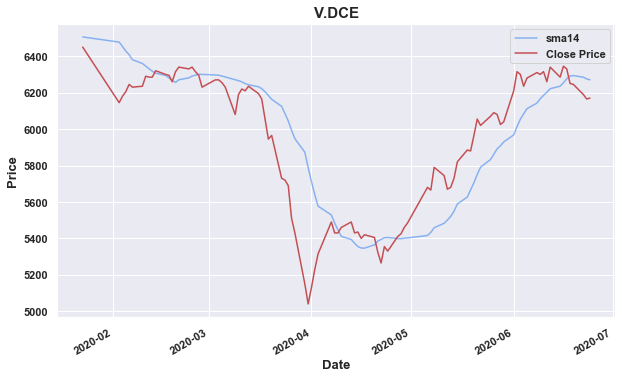

In [12]:
# Simple Moving Average
Ind.sma(ticker='AAPL')
Ind.sma(contract='V.DCE')

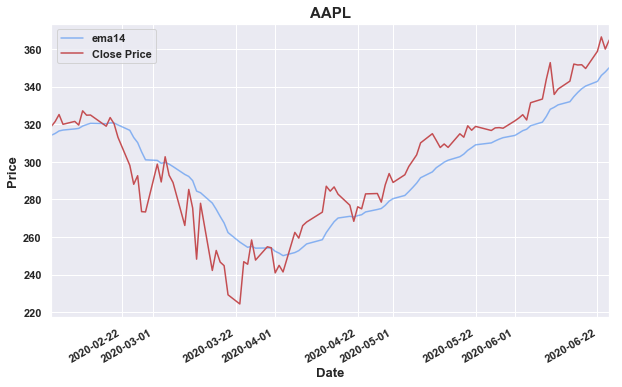

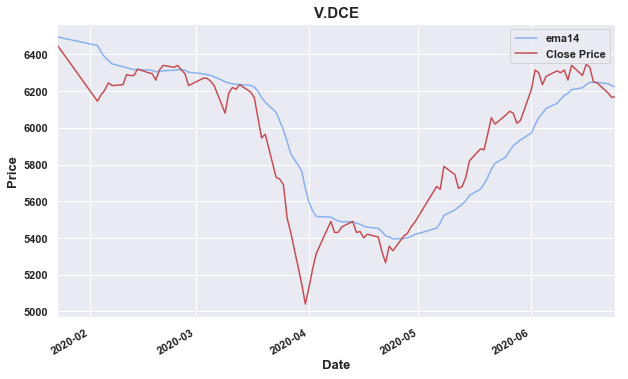

In [275]:
# Exponential Moving Average
Ind.ema(ticker='AAPL')
Ind.ema(contract='V.DCE')

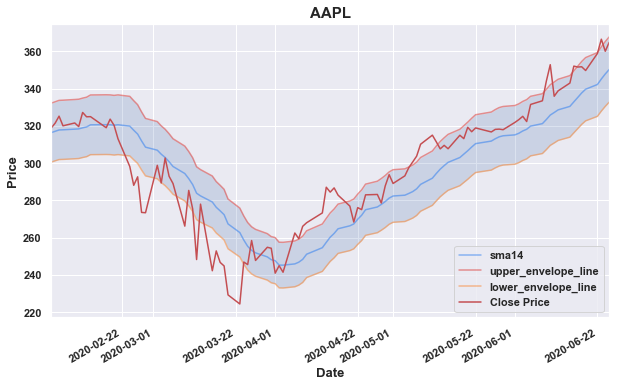

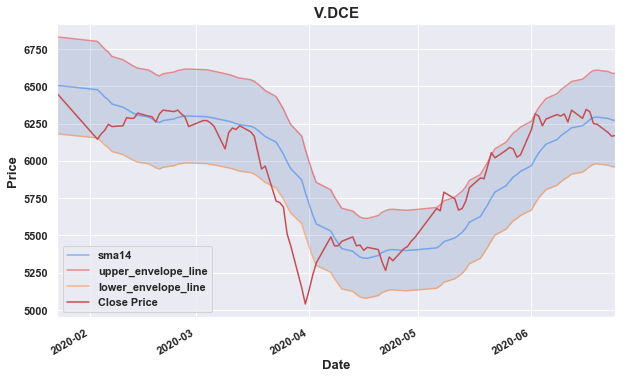

In [278]:
# Moving Average Envelope
Ind.ma_envelope(ticker='AAPL')
Ind.ma_envelope(contract='V.DCE')

In [306]:
# PSAR
Ind.psar(ticker='AAPL')
# Ind.pivot(contract='V.DCE')

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.513393    0.515625    0.513393    0.513393    0.405683   
1980-12-15    0.488839    0.488839    0.486607    0.486607    0.384517   
1980-12-16    0.453125    0.453125    0.450893    0.450893    0.356296   
1980-12-17    0.462054    0.464286    0.462054    0.462054    0.365115   
1980-12-18    0.475446    0.477679    0.475446    0.475446    0.375698   
...                ...         ...         ...         ...         ...   
2020-06-19  354.640015  356.559998  345.149994  349.720001  349.720001   
2020-06-22  351.339996  359.459991  351.149994  358.869995  358.869995   
2020-06-23  364.000000  372.380005  362.269989  366.529999  366.529999   
2020-06-24  365.000000  368.790009  358.519989  360.059998  360.059998   
2020-06-25  360.700012  365.000000  357.570007  364.839996  364.839996   

               Volume Ticker trends  

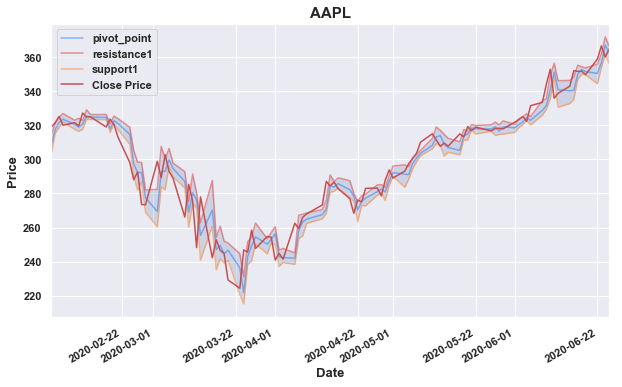

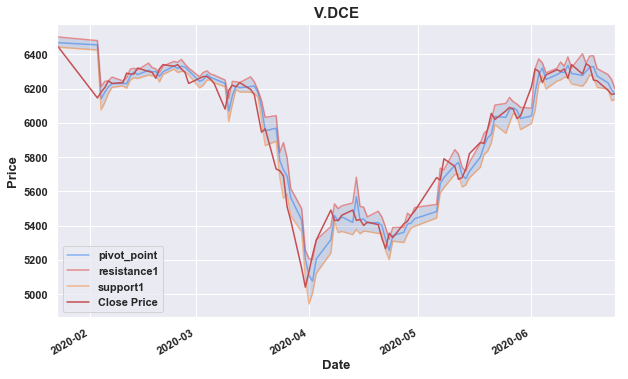

In [293]:
# Pivot Point
Ind.pivot(ticker='AAPL')
Ind.pivot(contract='V.DCE')

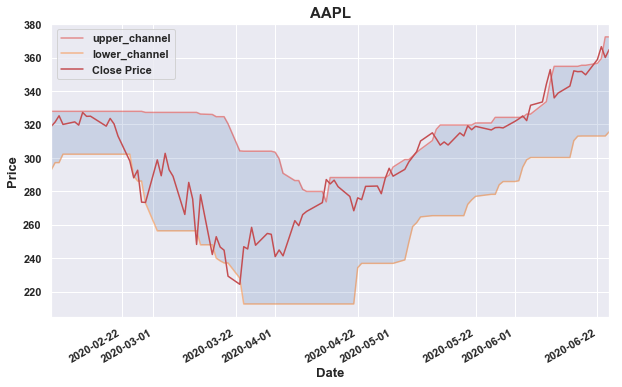

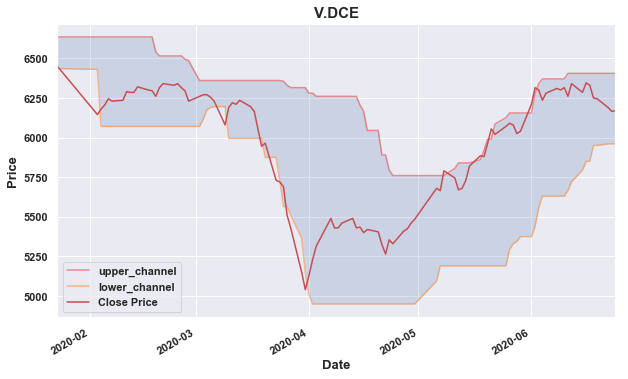

In [303]:
# Price Channels
Ind.price_channels(ticker='AAPL')
Ind.price_channels(contract='V.DCE')

In [307]:
# Price by volume

In [308]:
# VWAP

In [309]:
# Zigzag

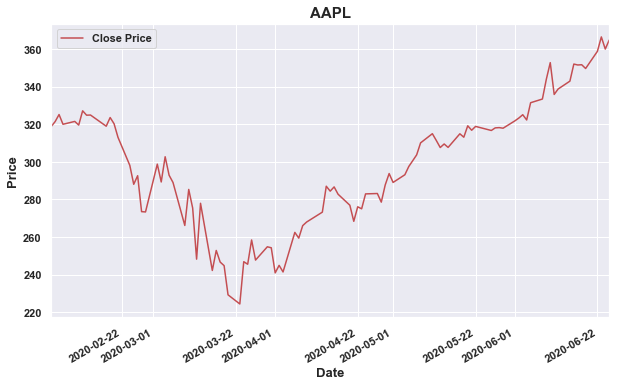

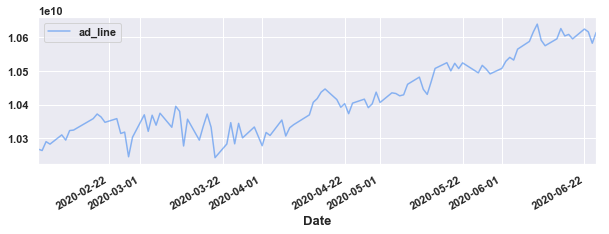

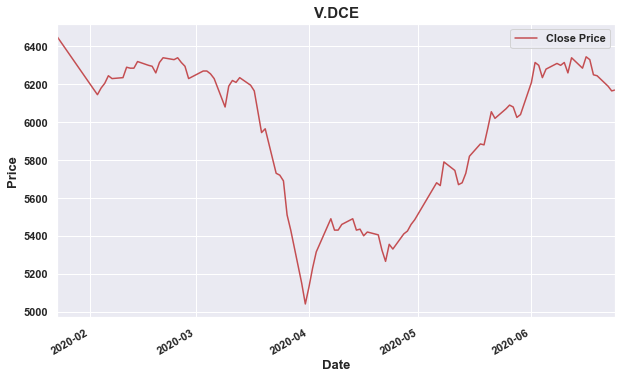

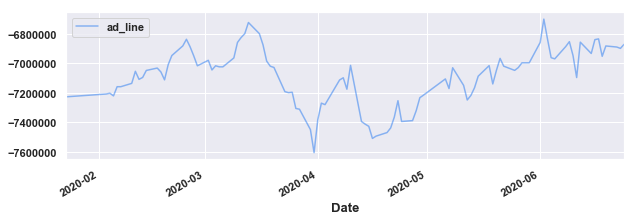

In [356]:
# Accumulation/Distribution Line
Ind.ad_line(ticker='AAPL')
Ind.ad_line(contract='V.DCE')

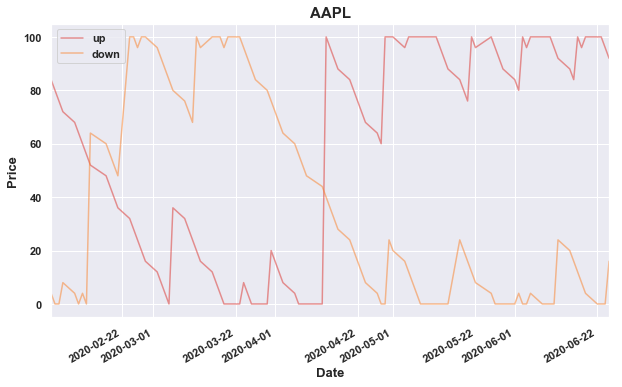

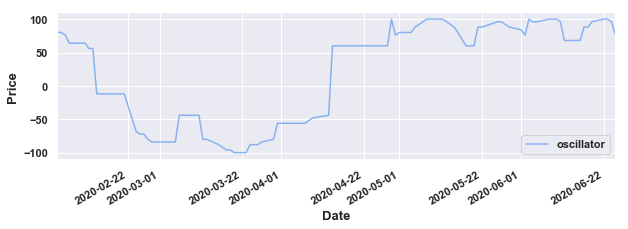

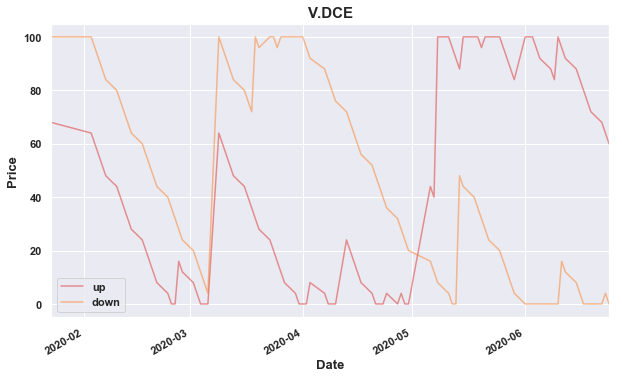

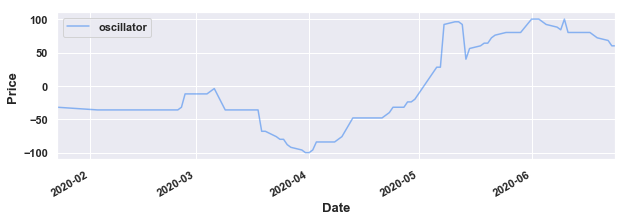

In [463]:
# Aroon
Ind.aroon(ticker='AAPL')
Ind.aroon(contract='V.DCE')

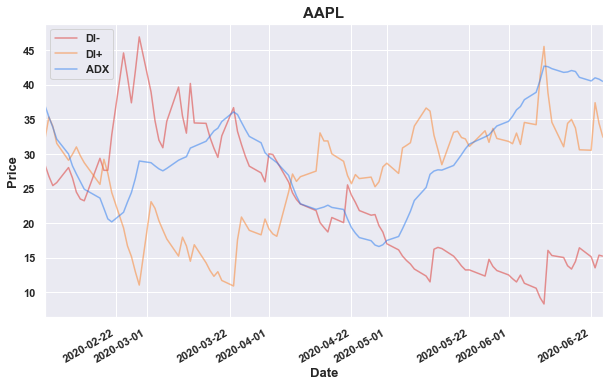

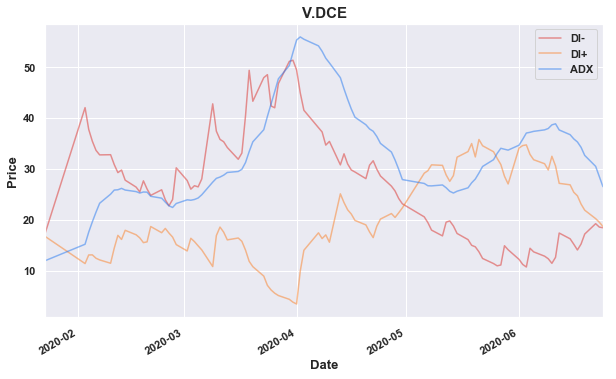

In [495]:
# ADX
Ind.adx(ticker='AAPL')
Ind.adx(contract='V.DCE')